In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import astropy.units as u

import dynesty
from dynesty import NestedSampler
from scipy.stats import norm
from dynesty import plotting as dyplot

In [2]:
NSIDE = 64
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

Approximate resolution at NSIDE 64 is 0.92 deg


In [3]:
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

49152


In [4]:
def pixel_angles(x,y,z,x_dip,y_dip,z_dip):
    dot_product = x*x_dip + y*y_dip + z*z_dip
    theta = np.arccos(dot_product) # don't need the magnitude bc they are unit vectors
    return theta

def poisson_sampling(NSIDE, D, N_mean, dipole_theta, dipole_phi):
    x,y,z = hp.pix2vec(NSIDE, np.arange(NPIX))
    x_dip, y_dip, z_dip = hp.ang2vec(dipole_theta, dipole_phi) 
    theta = pixel_angles(x,y,z,x_dip,y_dip,z_dip)
    lambda_ = N_mean * (1 + D*np.cos(theta))
    sample = np.random.poisson(lambda_)
    return sample, lambda_
        
def plotting(m, dipole_theta=None, dipole_phi=None, title=None, unit=None, cmap='viridis'):
    projview(m, title=title, unit=unit,
    graticule=True, graticule_labels=True, projection_type="mollweide", cmap=cmap);

    newprojplot(theta=dipole_theta, phi=dipole_phi, marker="*", color="k", markersize=15);
    plt.tight_layout()
#     plt.show()
#     plt.close()
    return

def omega_to_theta(omega):
    '''Convert solid angle in steradins to theta in radians for
    a cone section of a sphere. Taken from the code used in Secrest (2021),
    namely in CatWISE_Dipole_Resulys.ipynb. '''
    return np.arccos(1 - omega / (2 * np.pi)) * u.rad

def compute_smooth_map(m: np.ndarray, weights=None, angle_scale=1):
        'Smooth the map using a moving average.'
        included_pixels = np.where(~np.isnan(m))[0]
        smoothed_map = np.full(m.shape, np.nan, dtype=float)
        nside = hp.get_nside(m)
        
        if type(weights) != np.ndarray:
            weights = np.ones_like(m).astype('float')

        smoothing_radius = omega_to_theta(angle_scale).value
        for p_index in included_pixels:
            vec = hp.pix2vec(nside, p_index)
            disc = hp.query_disc(nside, vec, smoothing_radius)
#             smoothed_map[p_index] = np.nanmean(m[disc] * weights[disc])
            smoothed_map[p_index] = np.nanmean(m[disc].astype(float) * weights[disc].astype(float))

        return smoothed_map

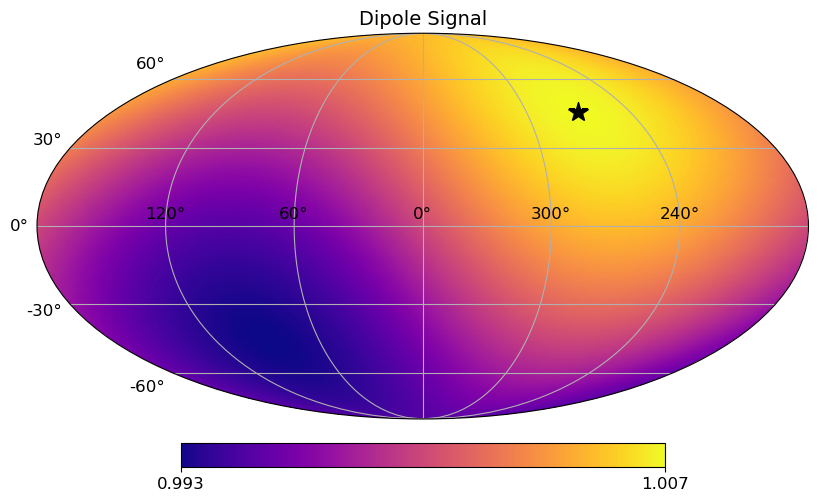

In [6]:
N_mean = 10
D = 0.007 # dipole amplitude, using value from paper
x,y,z = hp.pix2vec(NSIDE, np.arange(NPIX)) # pixel vectors

#  dipole vector
dipole_theta = np.pi/4
dipole_phi = -np.pi/2
x_dip, y_dip, z_dip = hp.ang2vec(dipole_theta, dipole_phi) 

# Angle calculation
theta = pixel_angles(x,y,z,x_dip,y_dip,z_dip)

# 'Raw signal'
m = 1 + D*np.cos(theta)

# Plotting the results
plotting(m, dipole_theta, dipole_phi,
         'Dipole Signal', '',
        cmap='plasma')
# plt.savefig('./dipole_signal.png',dpi=300)


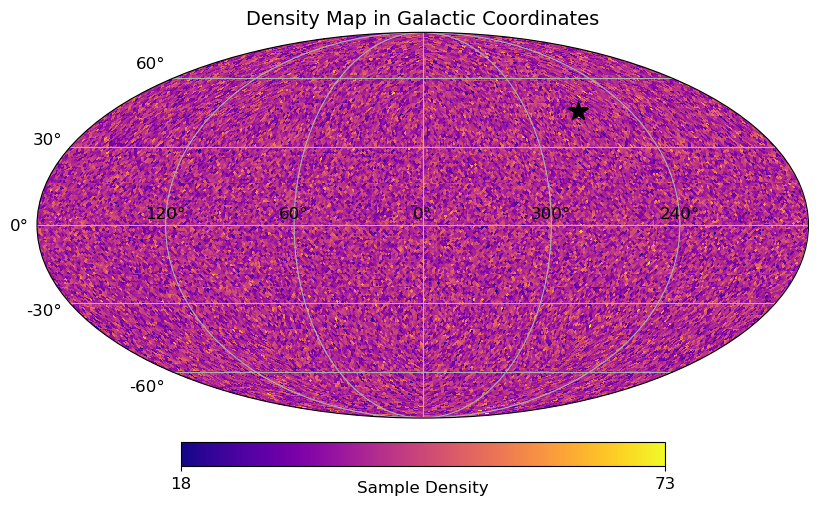

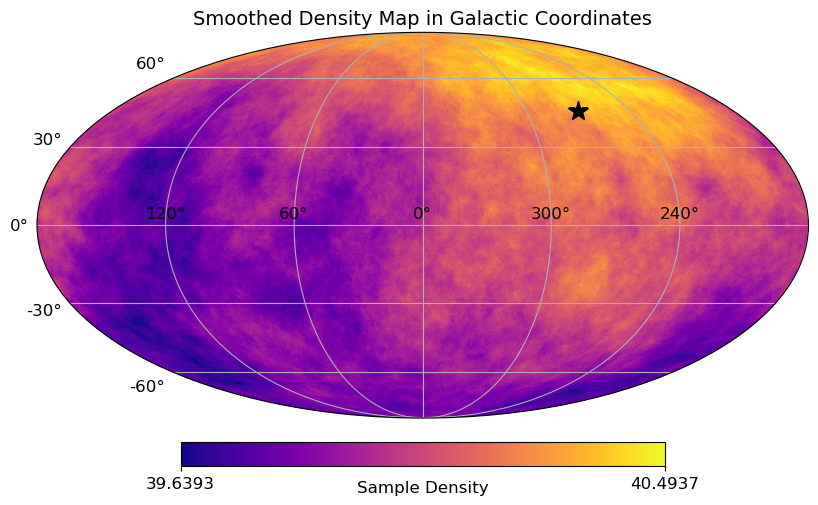

In [8]:
m, lambda_ = poisson_sampling(NSIDE=64, D=0.007, N_mean=40, dipole_theta=np.pi/4, dipole_phi=-np.pi/2)

#Unsmoothed
plotting(m, dipole_theta, dipole_phi,
         title='Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')
# plt.savefig('./dipole_distribution.png',dpi=300)

smoothed_map = compute_smooth_map(m, weights=None, angle_scale=1)

plotting(smoothed_map, dipole_theta, dipole_phi,
         title='Smoothed Density Map in Galactic Coordinates', unit="Sample Density",
        cmap='plasma')

# plt.savefig('./smoothed_dipole_distribution.png',dpi=300)

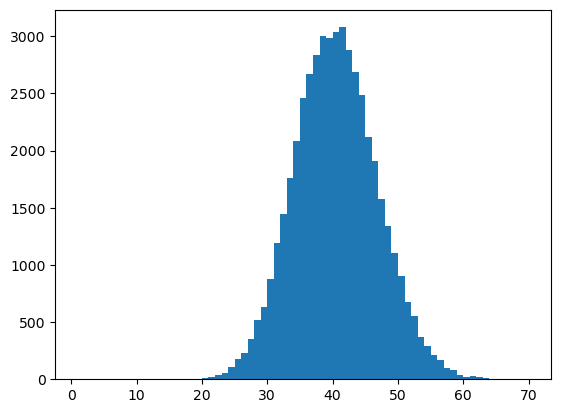

1966354


In [7]:
bins=np.linspace(1,70,70)
plt.hist(m, bins=bins)
plt.show()
print(sum(m))

In [30]:
def prior_transform(u):
    D = u[0]/10
    phi = u[1]*2*np.pi
    
    c = u[2]/10
    theta = np.arccos(1-2*c)
    return  D, phi, theta

# Choose a Gaussian likelihood for the data
def log_likelihood(theta):
    D, l, b = theta #amplitude, longitude and latitude 
    y_model = 
    return 


In [ ]:
# A Poisson distrubtuion has the form
# P(N_i | lambda_i) = lambda_i ^N_i * e^-lambda_i/ N_i !
# So the prob os seing count N_i given some parameter lambda_i is the RHS
# Our array of counts is 'y', and we want to extract the free parameters in lambda_i = N_bar * (1 + Dcos(theta))

# Likelihood function from Oliver's paper
# lnZ = sum(ln(N_i * f(p_i)/F))
# where F is a normalisation term F = sum(f(p_i))
# f depends on the model, for a dipole f = 1 + Dcos(theta_i)

In [29]:
sampler = NestedSampler(log_likelihood, prior_transform, ndim=3, nlive=1000)

sampler.run_nested()
results = sampler.results


(array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
        0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
 array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
        3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531]),
 array([[0.        , 0.67967382, 0.98176536, 1.23095942, 1.45945531,
         1.68213734, 1.91063324, 2.1598273 , 2.46191883, 3.14159265],
        [0.        , 0.67967382, 0.98176536, 1.23095942, 1.45945531,
         1.68213734, 1.91063324, 2.1598273 , 2.46191883, 3.14159265],
        [0.        , 0.67967382, 0.98176536, 1.23095942, 1.45945531,
         1.68213734, 1.91063324, 2.1598273 , 2.46191883, 3.14159265]]))